# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

### Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.preprocessing import StandardScaler

from numpy.random import RandomState
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format

# зададим темный стиль оформления background для всех следующих графиков
sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('/datasets/gold_recovery_full_new.csv')
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [3]:
def data_check(data, title):
    print('--------------- Общая информация датасэта', title, '---------------')
    print()
    display(data.info())
    
    print('Первые 5 строк датасэта:')
    display(data.head(5))
    print()
    
    print('Описательная статистика датасэта:')
    display(data.describe())
    print()
    
    print('Количество дубликатов:', data.duplicated().sum())

In [4]:
data_check(data, '"исходные данные"')

--------------- Общая информация датасэта "исходные данные" ---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8  

None

Первые 5 строк датасэта:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,3


Описательная статистика датасэта:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"19,438.00","19,438.00","19,228.00","19,439.00","19,439.00","19,438.00","19,338.00","19,433.00","19,439.00","19,415.00","19,402.00","19,439.00","19,335.00","19,439.00","19,323.00","19,069.00","19,439.00","19,435.00","19,418.00","19,377.00","19,439.00","19,435.00","19,438.00","19,435.00","19,438.00","19,437.00","19,438.00","19,436.00","19,438.00","19,437.00","19,437.00","19,437.00","19,439.00","19,439.00","19,339.00","19,428.00","19,294.00","19,340.00","19,439.00","19,405.00","19,431.00","19,395.00","18,986.00","19,439.00","19,439.00","19,416.00","19,439.00","19,439.00","19,438.00","19,439.00","19,439.00","19,439.00","19,438.00","19,438.00","19,438.00","19,438.00","19,438.00","19,438.00","19,439.00","19,439.00","19,003.00","19,439.00","19,439.00","19,439.00","19,437.00","19,427.00","17,691.00","19,439.00","19,219.00","19,438.00","19,416.00","19,438.00","19,426.00","19,438.00","19,438.00","19,438.00","19,433.00","19,438.00","19,438.00","19,438.00","19,438.00","19,438.00","19,438.00","19,438.00","19,437.00","19,438.00"
mean,5.17,9.98,9.50,44.08,67.05,9.69,2.


Количество дубликатов: 0


In [5]:
data_check(data_train, '"обучающая выборка"')

--------------- Общая информация датасэта "обучающая выборка" ---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8

None

Первые 5 строк датасэта:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,3


Описательная статистика датасэта:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"14,148.00","14,148.00","13,938.00","14,149.00","14,149.00","14,149.00","14,049.00","14,144.00","14,149.00","14,129.00","14,117.00","14,149.00","14,049.00","14,149.00","14,063.00","13,863.00","14,149.00","14,148.00","14,134.00","14,103.00","14,149.00","14,145.00","14,148.00","14,145.00","14,148.00","14,147.00","14,148.00","14,146.00","14,148.00","14,148.00","14,148.00","14,148.00","14,149.00","14,149.00","14,049.00","14,141.00","14,005.00","14,071.00","14,149.00","14,120.00","14,141.00","14,113.00","13,721.00","14,149.00","14,149.00","14,127.00","14,149.00","14,149.00","14,148.00","14,149.00","14,149.00","14,149.00","14,148.00","14,148.00","14,148.00","14,148.00","14,148.00","14,148.00","14,149.00","14,149.00","13,713.00","14,149.00","14,149.00","14,149.00","14,147.00","14,139.00","12,544.00","14,149.00","13,932.00","14,148.00","14,128.00","14,148.00","14,145.00","14,148.00","14,148.00","14,148.00","14,143.00","14,148.00","14,148.00","14,148.00","14,148.00","14,148.00","14,148.00","14,148.00","14,147.00","14,148.00"
mean,5.14,10.13,9.20,44.00,66.52,9.61,2


Количество дубликатов: 0


In [6]:
data_check(data_test, '"тестовая выборка"')

--------------- Общая информация датасэта "тестовая выборка" ---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary

None

Первые 5 строк датасэта:


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.80,14.99,8.08,1.01,"1,398.98",-500.23,"1,399.14",-499.92,"1,400.10",-500.70,"1,399.00",-499.49,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,"1,001.85",-350.30,"1,249.74",-399.11,"1,249.75",-399.40,"1,198.29",-399.49,999.47,-399.53,949.57,-398.18,24.94,-500.49,14.95,-500.01,20.02,-450.40,13.99,-449.83,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
1,2016-09-01 01:59:59,215.39,14.99,8.08,0.99,"1,398.78",-500.06,"1,398.06",-499.78,"1,396.15",-499.24,"1,399.51",-500.42,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,998.69,-350.43,"1,248.40",-399.95,"1,249.51",-399.63,"1,200.51",-399.94,"1,000.00",-399.49,950.20,-405.79,24.92,-499.81,14.93,-500.76,19.99,-450.11,14.09,-450.06,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2,2016-09-01 02:59:59,215.26,12.88,7.79,1.00,"1,398.49",-500.87,"1,398.86",-499.76,"1,398.08",-502.15,"1,399.50",-499.72,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,998.52,-349.78,"1,247.44",-400.26,"1,248.21",-401.07,"1,199.77",-400.79,999.93,-399.24,950.32,-400.86,24.91,-500.30,15.00,-500.99,20.04,-450.26,14.08,-449.66,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
3,2016-09-01 03:59:59,215.34,12.01,7.64,0.86,"1,399.62",-498.86,"1,397.44",-499.21,"1,400.13",-498.36,"1,401.07",-501.04,12.40,5.11,476.62,59.87,41.06,12.18,16.53,5.80,16.52,5.80,"1,000.28",-350.17,"1,251.32",-398.66,"1,250.49",-399.75,"1,199.40",-397.50,"1,001.93",-400.44,950.74,-399.80,24.89,-499.38,14.92,-499.86,20.03,-449.37,14.01,-449.53,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
4,2016-09-01 04:59:59,199.10,10.68,7.53,0.81,"1,401.27",-500.81,"1,398.13",-499.50,"1,402.17",-500.81,"1,399.48",-499.37,11.33,4.77,488.25,63.32,41.27,11.29,13.61,5.74,13.65,5.74,996.54,-350.56,"1,304.66",-399.51,"1,306.46",-399.05,"1,248.70",-400.88,"1,058.84",-398.99,949.65,-399.28,24.89,-499.36,14.98,-500.19,19.96,-450.64,14.01,-450.02,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86



Описательная статистика датасэта:


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"5,286.00","5,285.00","5,290.00","5,286.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,287.00","5,289.00","5,269.00","5,290.00","5,285.00","5,290.00","5,282.00","5,265.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,287.00","5,290.00","5,288.00","5,290.00","5,281.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00","5,290.00"
mean,174.84,8.68,7.27,1.38,"1,539.49",-497.67,"1,545.17",-500.27,"1,527.27",-498.33,"1,544.84",-500.20,9.37,3.80,489.80,55.95,37.72,9.33,13.86,6.47,13.92,6.51,"1,053.40",-395.73,"1,318.93",-475.24,"1,301.60",-474.84,"1,214.85",-475.68,"1,056.65",-469.03,997.95,-470.48,26.31,-502.75,21.95,-501.99,25.40,-507.49,20.98,-506.63,16.32,-505.14,13.74,-463.35,12.80,-501.33,9.88,-495.66,17.30,-501.79
std,43.03,3.07,0.61,0.64,116.80,19.95,122.22,32.97,122.54,21.96,124.77,31.05,1.93,0.95,108.04,19.08,5.49,1.62,3.35,1.07,3.22,0.89,121.14,91.09,156.45,45.65,171.27,45.86,185.76,47.84,131.54,59.33,128.22,60.76,3.43,28.76,4.35,34.58,6.53,47.62,6.74,44.53,3.49,31.43,3.43,86.19,3.03,17.95,2.87,34.54,4.54,39.04
min,2.57,0.00,5.65,0.00,0.00,-795.32,0.00,-800.00,0.00,-799.96,0.00,-799.79,0.57,0.27,0.00,0.05,1.39,0.57,0.00,0.00,0.00,0.01,-0.04,-657.95,-0.72,-650.25,-0.06,-647.54,-0.99,-648.39,-1.98,-649.27,-2.59,-649.95,0.21,-784.09,0.01,-797.78,0.00,-799.76,0.00,-809.33,0.00,-799.80,0.00,-800.84,0.07,-797.32,0.53,-800.22,-0.08,-809.74
25%,147.12,6.49,6.89,0.91,"1,498.94",-500.36,"1,498.97",-500.70,"1,473.23",-501.02,"1,499.48",-500.45,8.11,3.24,407.02,43.91,34.51,8.21,12.00,6.00,12.00,6.00,999.21,-499.92,"1,200.87",-500.26,"1,199.65",-500.23,"1,093.37",-500.44,999.36,-500.19,901.02,-500.62,24.94,-500.21,20.00,-500.22,22.98,-500.30,17.97,-500.15,14.04,-500.87,12.03,-500.32,10.91,-500.73,8.04,-500.19,14.00,-500.69
50%,177.83,8.05,7.25,1.20,"1,585.13",-499.97,"1,595.62",-500.03,"1,549.59",-500.02,"1,594.58",-500.02,9.76,3.74,499.05,50.84,37.98,9.5


Количество дубликатов: 0


В данных есть пропуски. Дубликаты во всех датасетах отсутствуют. В тестовой выборке нехватает столбцов с признаками.

### Проверка расчета эффективности обогащения

In [7]:
calculation_recovery = (
    data_train['rougher.output.concentrate_au'] * (
        data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au']
    )
) / (
    data_train['rougher.input.feed_au'] * (
        data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au']
    )
) * 100

In [8]:
mae_difference = (
    data_train['rougher.output.recovery'] - calculation_recovery
).abs().mean()

In [9]:
print('MAE: {:.20f}'.format(mae_difference))

MAE: 0.00000000000000973512


Значение MAE вышло очень низкое, показатель эффективности обогащения расчитан корректно.

### Анализ признаков, недоступных в тестовой выборке

In [10]:
def column_difference(df1, df2):
    return df1.columns.difference(df2.columns)

columns_test = column_difference(data, data_test)

print('В тестовой выборке отсутствует', columns_test.shape[0], 'столбца, а именно:')
print(columns_test)

В тестовой выборке отсутствует 34 столбца, а именно:
Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_

Всего нехватает 34 столбца. Среди них большое кол-во расчетных характеристик этапов флотации и целевые признаки:
- final.output.recovery
- rougher.output.recovery

Попробуем получить их из исходных данных по ключевому полю "date".

### Предобработка данных

Добавим к тестовой выборке целевые признаки из исходных данных по ключу date

In [11]:
data_test = data_test.merge(
    data[['date', 'rougher.output.recovery', 'final.output.recovery']],
    on='date',
    how='left'
)

С помощью ffill() заполним пропуски ближайшими значениями так как в условиях задачи есть пометка "Соседние по времени параметры часто похожи".

In [12]:
data.ffill(axis=0, inplace=True)
data_test.ffill(axis=0, inplace=True)
data_train.ffill(axis=0, inplace=True)

Удалим признаки из обучающей выборки, которые отсутствуют в тестовой.

In [13]:
data_train.drop(
    columns=column_difference(data_train, data_test),
    inplace=True
)

print('Кол-во столбцов в исходных данных:', data.shape[1])
print('Кол-во столбцов в тестовой выборке:', data_test.shape[1])
print('Кол-во столбцов в обучающей выборке:', data_train.shape[1])

Кол-во столбцов в исходных данных: 87
Кол-во столбцов в тестовой выборке: 55
Кол-во столбцов в обучающей выборке: 55


**Вывод**

Краткая выжимка по подготовке данных:
- тип данных у всех признаково определен корректно;
- в датасэтах отсутствуют дубликаты;
- показатель эффективности обогащения расчитан правильно;
- к тестовой выборке добавлены целевые признаки "final.output.recovery", "rougher.output.recovery";
- Nan значения заменены методом ffill();
- из обучающей выборки удалили признаки, которых нет в тестовой.

## Анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Функция вывода графиков для определения концентрации металлов

In [14]:
def metal_conc_plot(metal, title):
    union_metal_conc = data[
        [
            'rougher.input.feed_' + metal,
            'rougher.output.concentrate_' + metal,
            'primary_cleaner.output.concentrate_' + metal,
            'final.output.concentrate_' + metal
        ]
    ].rename(
        columns={
            'rougher.input.feed_' + metal: 'Начальный',
            'rougher.output.concentrate_' + metal: 'Флотация',
            'primary_cleaner.output.concentrate_' + metal: 'Первичная_очистка',
            'final.output.concentrate_' + metal: 'Финальные_характеристики',
        }
    )
    
    
    # график распределения
    fig = plt.subplots(figsize=(17, 10))
    for column in union_metal_conc.columns:
        union_metal_plot = sns.distplot(
            union_metal_conc[column],
            kde=False,
            label=column
        )
        
    union_metal_plot.set(
        title='Концентрация ' + title + ' на различных этапах очистки',
        yticklabels=[],
        ylabel=None,
        xlabel=None
    )
        
    plt.legend()

    # ящик с усами
    fig = plt.subplots(figsize=(17, 5))
    sns.boxplot(
        x='value', 
        y='variable', 
        data=pd.melt(union_metal_conc),
        width=.4
    ).set(
        yticklabels=[],
        ylabel=None,
        xlabel=None
    )
    plt.show()

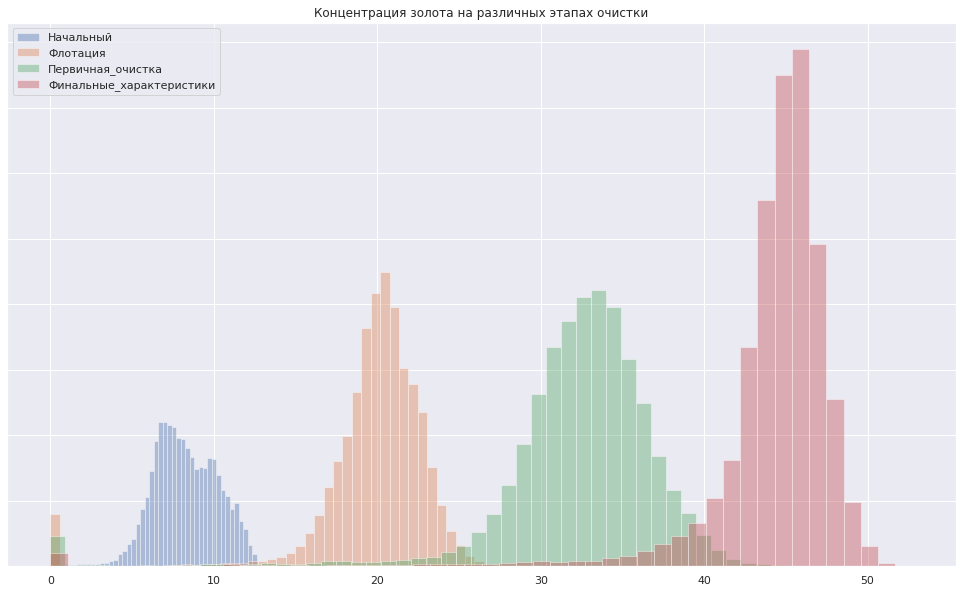

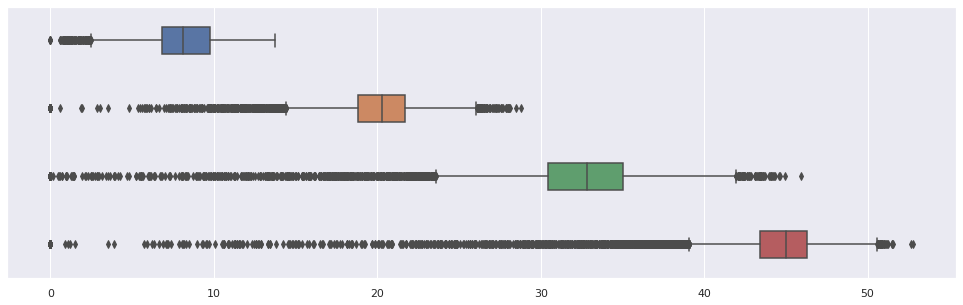

In [15]:
metal_conc_plot('au', 'золота')

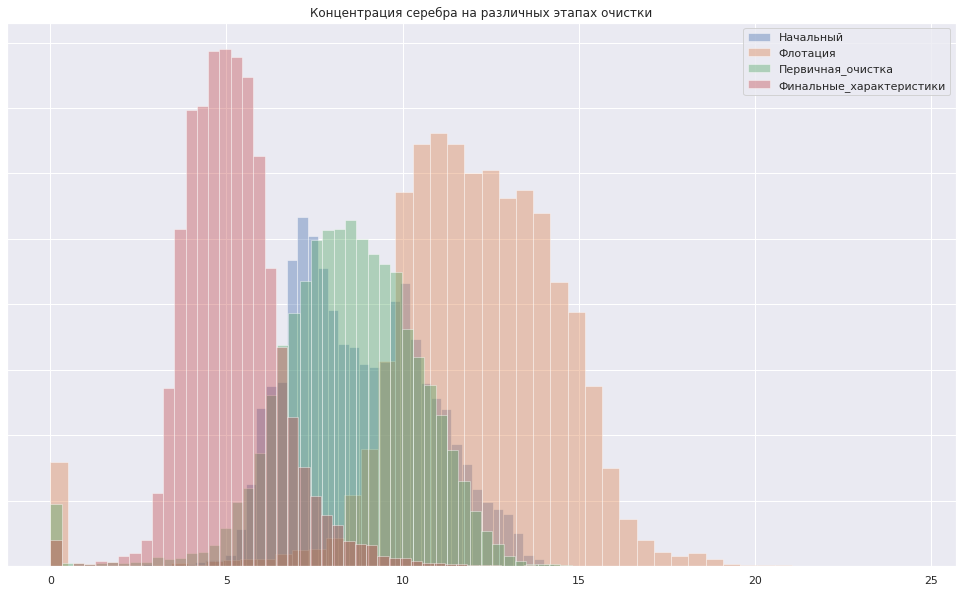

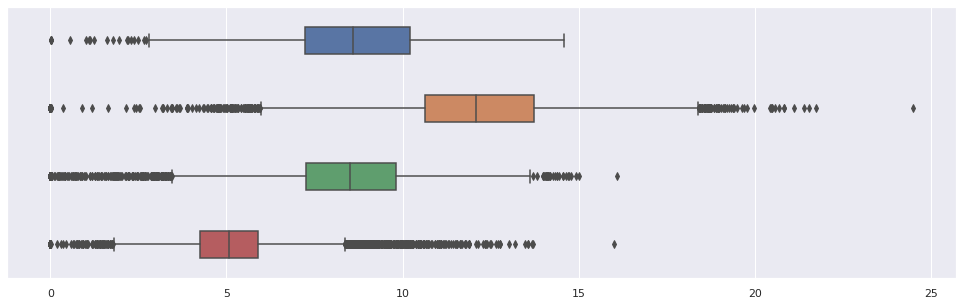

In [16]:
metal_conc_plot('ag', 'серебра')

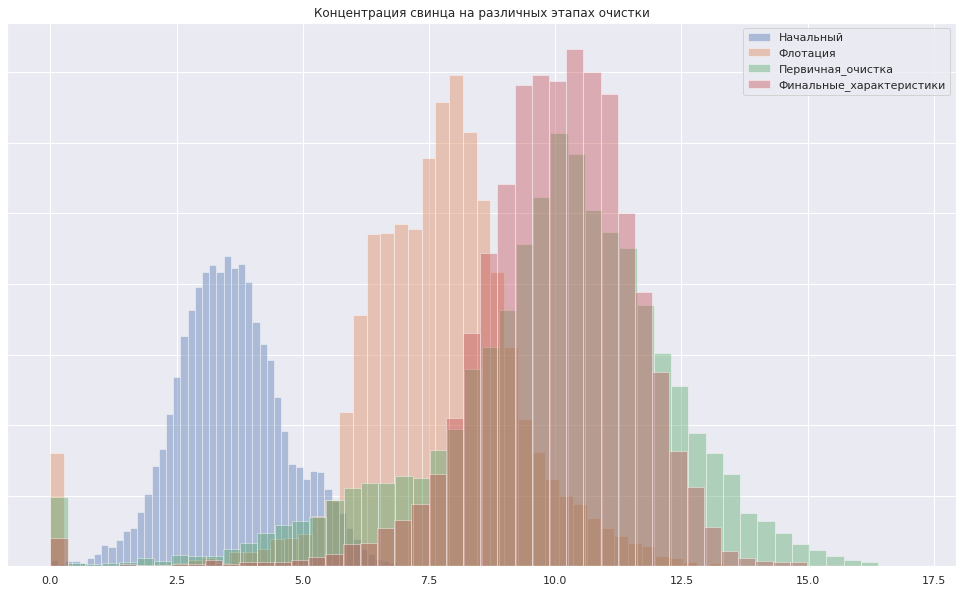

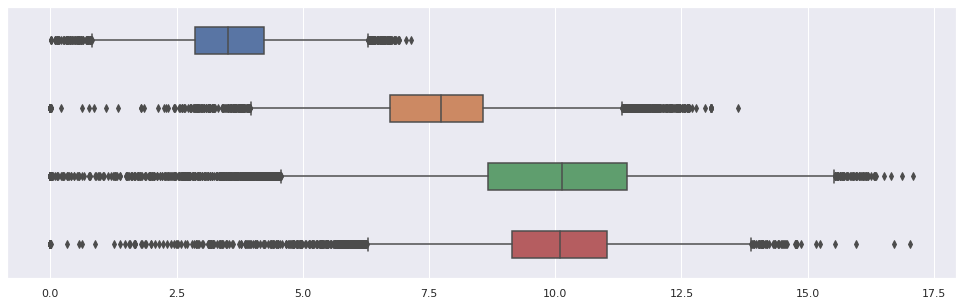

In [17]:
metal_conc_plot('pb', 'свинца')

По графикам можно сделать следующие выводы:
- концентрация золота растет на каждом этапе;
- максимальное значение у серебра наблюдается после флотации;
- концентрация свинца возрастает на последних двух этапах, при чем по концентрации они очень похожи.

### Распределение размеров гранул сырья на обучающей и тестовой выборках

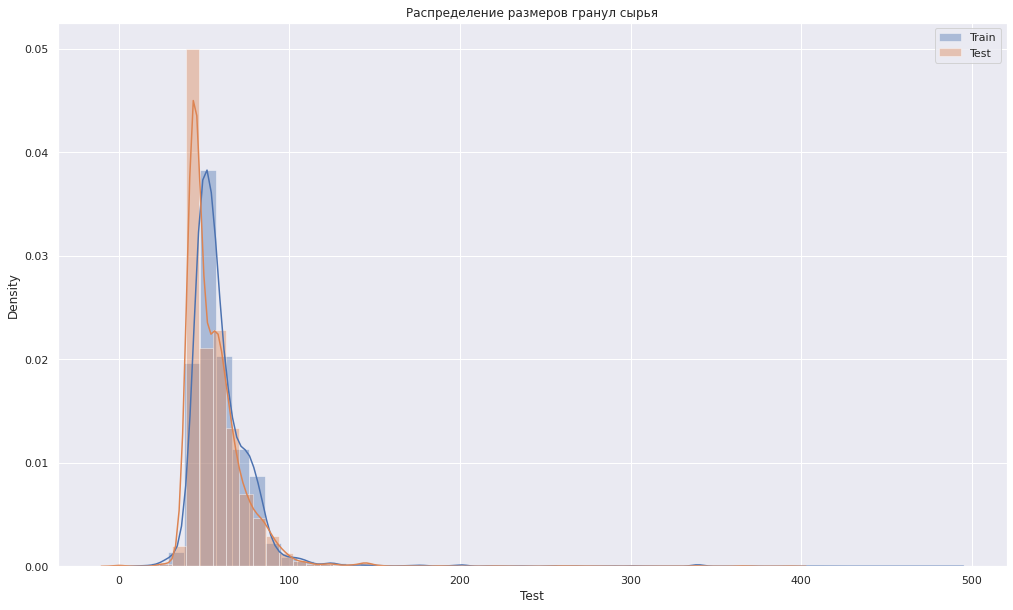

In [18]:
data_granule_size = pd.concat(
    [
        data_train['rougher.input.feed_size'],
        data_test['rougher.input.feed_size'],
    ], 
    axis=1,
    keys=[
        'Train',
        'Test'
    ]
)

fig = plt.subplots(figsize=(17, 10))
for column in data_granule_size.columns:
    sns.distplot(
        data_granule_size[column],
        kde=True,
        label=column
    ).set(
        title='Распределение размеров гранул сырья'
    )
    
plt.legend()
plt.show()

Распределения имеют небольшие отличия, но в целом картина давольно однородная.

### Суммарная концентрация всех веществ на разных стадиях

In [19]:
rougher_input_feed = (
    data['rougher.input.feed_au'] 
    + data['rougher.input.feed_ag'] 
    + data['rougher.input.feed_pb']
)

rougher_output_concentrate = (
    data['rougher.output.concentrate_au'] 
    + data['rougher.output.concentrate_ag'] 
    + data['rougher.output.concentrate_pb']
)

primary_cleaner_output_concentrate = (
    data['primary_cleaner.output.concentrate_au'] 
    + data['primary_cleaner.output.concentrate_ag'] 
    + data['primary_cleaner.output.concentrate_pb']
)

final_output_concentrate = (
    data['final.output.concentrate_au'] 
    + data['final.output.concentrate_ag'] 
    + data['final.output.concentrate_pb']
)

In [20]:
union_all_metal_conc = pd.concat(
    [
        rougher_input_feed, 
        rougher_output_concentrate, 
        primary_cleaner_output_concentrate, 
        final_output_concentrate
    ], 
    axis=1,
    keys=[
        'Начальный',
        'Флотация',
        'Первичная_очистка',
        'Финальные_характеристики'        
    ]
)

In [21]:
def union_metal_conc_plot(df):
    fig = plt.subplots(figsize=(17, 10))
    
    for column in df.columns:
        union_all_metal_plot = sns.distplot(
            df[column],
            kde=False,
            label=column
        )

    union_all_metal_plot.set(
        title='Совокупная концентрация всех драг.металлов на различных этапах очистки',
        yticklabels=[],
        ylabel=None,
        xlabel=None
    )
    plt.legend()

    fig = plt.subplots(figsize=(17, 5))
    
    sns.boxplot(
        x='value', 
        y='variable', 
        data=pd.melt(df),
        width=.4
    ).set(
        yticklabels=[],
        ylabel=None,
        xlabel=None
    )

    plt.show()

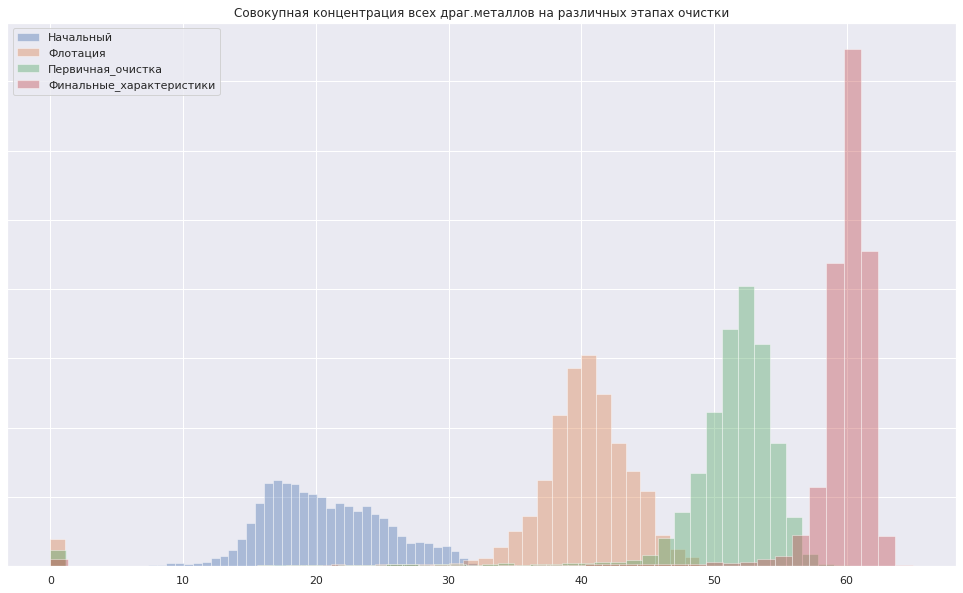

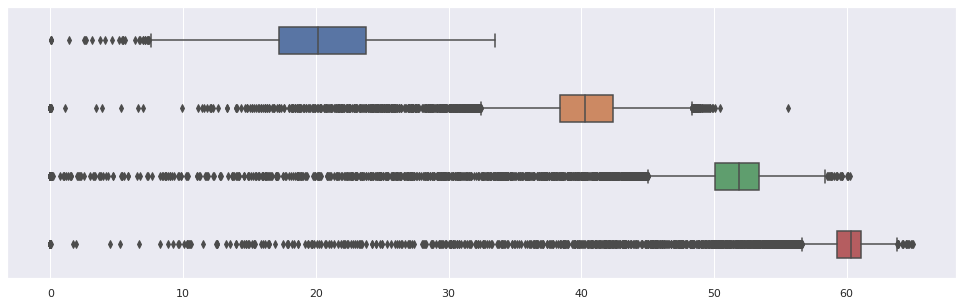

In [22]:
union_metal_conc_plot(union_all_metal_conc)

Ящик с усами наглядно отображает большое кол-во выбросов на всех этапах очистки, попробуем избавиться от них.

In [23]:
rougher_input_down = union_all_metal_conc['Начальный'].quantile(.025)
rougher_input_up = union_all_metal_conc['Начальный'].quantile(.975)

rougher_output_down = union_all_metal_conc['Флотация'].quantile(.025)
rougher_output_up =union_all_metal_conc['Флотация'].quantile(.975)

primary_cleaner_output_down = union_all_metal_conc['Первичная_очистка'].quantile(.025)
primary_cleaner_output_up = union_all_metal_conc['Первичная_очистка'].quantile(.975)

final_output_down = union_all_metal_conc['Финальные_характеристики'].quantile(.025)
final_output_up = union_all_metal_conc['Финальные_характеристики'].quantile(.975)

clear_all_metal_conc = union_all_metal_conc.query(
    '@rougher_input_down < Начальный < @rougher_input_up & @rougher_output_down < Флотация < @rougher_output_up & @primary_cleaner_output_down < Первичная_очистка < @primary_cleaner_output_up & @final_output_down < Финальные_характеристики < @final_output_up'
)

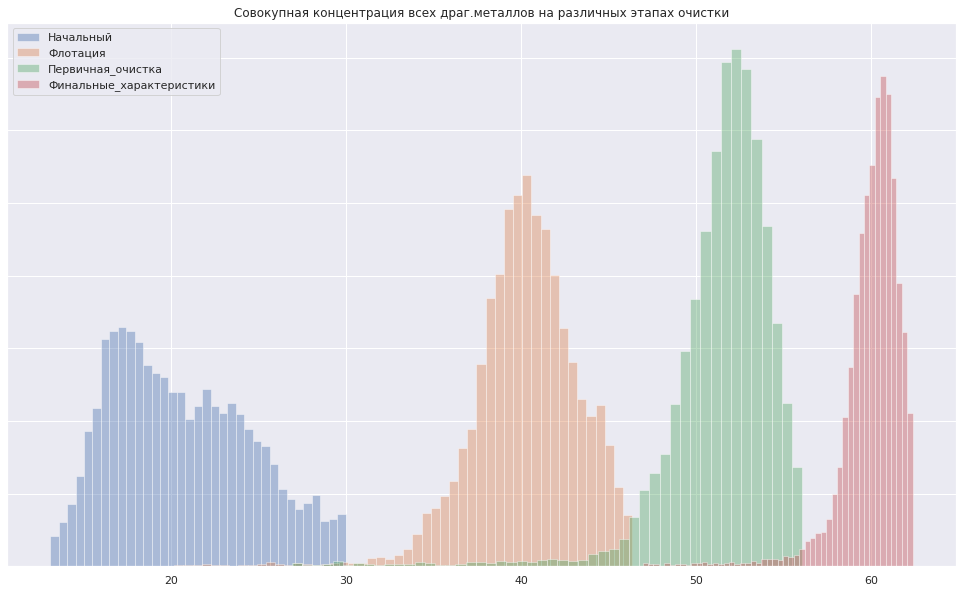

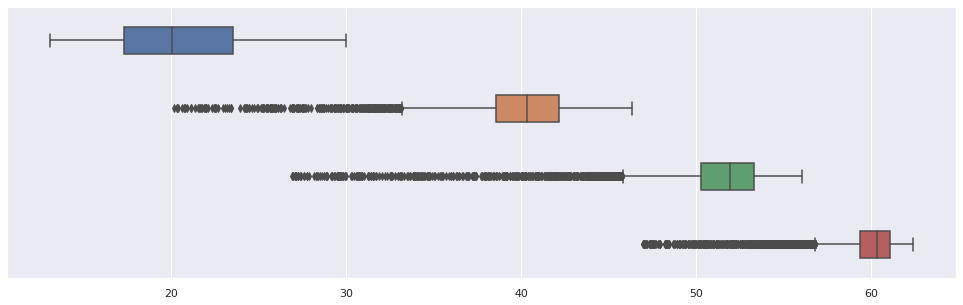

In [24]:
union_metal_conc_plot(clear_all_metal_conc)

Поскольку мы избавились от выбросов только в группированной таблице основанной на исходных данных, дополнительно нудно удалить эти же строки по индексу из исходной выборки, тествой и обучающей.

In [25]:
def set_delete(more_df, less_df):
    result = set(more_df.index.values) - set(less_df.index.values)    
    
    return result

data = data.drop(
    labels=list(
        set_delete(data, clear_all_metal_conc).intersection(set(data.index.values))
    ),
    axis = 0
)

data_test = data_test.drop(
    labels=list(
        set_delete(data, data_test).intersection(set(data_test.index.values))
    ),
    axis = 0
)

data_train = data_train.drop(
    labels=list(
        set_delete(data, data_train).intersection(set(data_train.index.values))
    ),
    axis = 0
)

**Вывод**

Если рассматривать по отдельности каждый металл, то концентрация на всех этапах сильно разнится. В совокупности же, видно общее повышение содержания металлов в руде после каждого этапа очистки.

## Модель

### Вычисление итогового sMAPE

In [26]:
def smape_calculate(target, predict):
    return abs(
        1 / len(target) * (
            (
                ( abs(target - predict) ) / ( (abs(target) + abs(predict)) / 2 )
            ).sum()
        ) * 100
    )

### Обучение моделей

Из обучающей и тестовой выборках удалим столбцы с датами. Так же отделим наши признаки от целевых значений.

In [27]:
data_test.drop(['date'], axis=1, inplace=True)
data_train.drop(['date'], axis=1, inplace=True)

features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]

features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]

Масштабируем наши признаки на всех выборках. Но сперва обучим StandardScaler на обучающей выборке.

In [28]:
# var_numeric = features_train.columns

# scaler = StandardScaler()
  
# features_train[var_numeric] = scaler.fit_transform(
#     features_train[var_numeric]
# )
# features_test[var_numeric] = scaler.transform(
#     features_test[var_numeric]
# )

Определим глобальные переменные для обучения моделей

In [29]:
RND_ST = RandomState(12345)

# Кросс валидация с помощью kFold
CV = KFold(
    n_splits=5,
    shuffle=False
)

SMAPE_SCORE = make_scorer(
    smape_calculate,
    greater_is_better=False
)

In [30]:
def grid_search(model, param):
    model_grid_rougher = GridSearchCV(
        model,
        param_grid=param,
        scoring=SMAPE_SCORE,
        cv=CV
    )
    
    model_grid_final = GridSearchCV(
        model,
        param_grid=param,
        scoring=SMAPE_SCORE,
        cv=CV
    )
    
    gscv_rougher = model_grid_rougher.fit(
        features_train,
        target_train['rougher.output.recovery']
    )

    gscv_final = model_grid_final.fit(
        features_train,
        target_train['final.output.recovery']
    )
    
    print('Лучшие параметры rougher:', gscv_rougher.best_params_)
    print('Smape rougher:', abs(gscv_rougher.best_score_))
    print()
    
    print('Лучшие параметры final:', gscv_final.best_params_)
    print('Smape final:', abs(gscv_final.best_score_))
    print()
    
    smape_result = .25 * gscv_rougher.best_score_ + .75 * gscv_final.best_score_
    print('Итоговое smape:', abs(smape_result))
    
    return model_grid_rougher, model_grid_final

#### DecisionTreeRegressor

In [31]:
model_dtr = DecisionTreeRegressor(random_state=RND_ST)

parameters_dtr = {
    'max_depth': range(1, 10)
}

grid_rougher_dtr, grid_final_dtr = grid_search(model_dtr, parameters_dtr)

Лучшие параметры rougher: {'max_depth': 4}
Smape rougher: 11.579887512182543

Лучшие параметры final: {'max_depth': 3}
Smape final: 10.806104806167777

Итоговое smape: 10.999550482671468


#### RandomForestRegressor

In [32]:
model_rfr = RandomForestRegressor(random_state=RND_ST)

parameters_rfr = {
    'max_depth': range(1, 5),
    'n_estimators': range(1, 31, 10)
}

grid_rougher_rfr, grid_final_rfr = grid_search(model_rfr, parameters_rfr)

Лучшие параметры rougher: {'max_depth': 4, 'n_estimators': 21}
Smape rougher: 11.05203125567434

Лучшие параметры final: {'max_depth': 4, 'n_estimators': 11}
Smape final: 10.21287033431111

Итоговое smape: 10.422660564651917


#### CatBoostRegressor

In [35]:
model_cbr = CatBoostRegressor(random_state=12345)

parameters_cbr = {
    'depth': range(1, 5),
    'n_estimators': range(1, 2),
    'l2_leaf_reg': range(1, 2),
    'verbose': [False]
}

grid_rougher_cbr, grid_final_cbr = grid_search(model_cbr, parameters_cbr)

Лучшие параметры rougher: {'depth': 3, 'l2_leaf_reg': 1, 'n_estimators': 1, 'verbose': False}
Smape rougher: 12.150660314270791

Лучшие параметры final: {'depth': 4, 'l2_leaf_reg': 1, 'n_estimators': 1, 'verbose': False}
Smape final: 11.29893337644969

Итоговое smape: 11.511865110904967


### Предсказания на тестовой выборке

In [36]:
def best_grid_search(column, model):
    model.fit(
        features_train,
        target_train[column]
    )
    grid_predict = model.predict(features_test)

    smape = smape_calculate(target_test[column], grid_predict)
    print('Best smape ' + column + ':', smape)
    
    return smape

In [37]:
smape_rougher = best_grid_search('rougher.output.recovery', grid_rougher_cbr.best_estimator_)
smape_final = best_grid_search('final.output.recovery', grid_final_cbr.best_estimator_)

best_smape = .25 * smape_rougher + .75 * smape_final

print('Итоговое smape:', best_smape)

Best smape rougher.output.recovery: 10.425405135714698
Best smape final.output.recovery: 10.182872097222889
Итоговое smape: 10.24350535684584


### Проверка на DummyRegressor

In [38]:
model_dr = DummyRegressor(strategy='mean')

smape_rougher_dr = best_grid_search('rougher.output.recovery', model_dr)
smape_final_dr = best_grid_search('final.output.recovery', model_dr)

best_smape_dr = .25 * smape_rougher_dr + .75 * smape_final_dr

print('Итоговое smape:', best_smape_dr)

Best smape rougher.output.recovery: 10.379799283438494
Best smape final.output.recovery: 10.25957407354855
Итоговое smape: 10.289630376021035


## Общий вывод

После обработки данных и поиска оптимальной модели, нам удалось получить коэффициент восстановления золота из руды. В проекте мы протестировали 3 модели и с помощью GridSearchCV подобрали лучшие гиперпараметры, а именно:
- DecisionTreeRegressor. <b>Для rougher -</b> 'max_depth': 4. <b>Для final -</b> 'max_depth': 3. <b>sMAPE</b> равен 10.9995;

- RandomForestClassifier. <b>Для rougher -</b> 'max_depth': 4, 'n_estimators': 21. <b>Для final -</b> 'max_depth': 4, 'n_estimators': 11. <b>sMAPE</b> равен 10.4226;

- CatBoostRegressor. <b>Для rougher -</b> 'depth': 3, 'l2_leaf_reg': 1, 'n_estimators': 1. <b>Для final -</b> 'depth': 4, 'l2_leaf_reg': 1, 'n_estimators': 1. <b>sMAPE</b> равен 11.5118

Для предсказаний на тестовой выборке была выбрана модель CatBoostRegressor. Итоговый sMAPE = 10.2435